In [49]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


df_originale = pd.read_csv("students_inf_mio.csv", sep=";")
df_riferimento = pd.read_csv("riferimento.csv", sep=";")

/var/folders/nl/1_4ghy_d0zq7rkhdbvtt54yw0000gn/T/ipykernel_1020/1209916502.py:11: DtypeWarning: Columns (8,17,37,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_originale = pd.read_csv("students_inf_mio.csv", sep=";")


In [72]:
colonne_da_tenere = df_riferimento[df_riferimento["KEEP"] == 1]["FEATURE"].values
df_originale_cleaned = df_originale[colonne_da_tenere]

#df_riferimento_cleaned = df_riferimento[df_riferimento['KEEP'] != 0]
df_riferimento_cleaned = df_riferimento.drop(df_riferimento[df_riferimento['KEEP'] == 0].index)
df_originale_cleaned['highschool_grade_normalized'] = (df_originale_cleaned["highschool_grade"] / df_originale_cleaned['highschool_grade_max']) * 100
nuova_riga = {'FEATURE': 'highschool_grade_normalized', 'ENCODING': 'ordinal', 'KEEP': 1}
df_riferimento_cleaned = df_riferimento_cleaned.append(nuova_riga, ignore_index=True)

def g(age):
  if age <= 17:
    return '16-17'
  elif age <= 19:
    return '18-19'
  elif age <= 23:
    return '20-23'
  elif age <= 27:
    return '24-27'
  else:
    return 'over 28'

df_originale_cleaned['age_group'] = df_originale_cleaned['stud_career_admission_age'].apply(g)
nuova_riga = {'FEATURE': 'age_group', 'ENCODING': 'ordinal', 'KEEP': 1}
df_riferimento_cleaned = df_riferimento_cleaned.append(nuova_riga, ignore_index=True)

df_originale_cleaned

/var/folders/nl/1_4ghy_d0zq7rkhdbvtt54yw0000gn/T/ipykernel_1020/573215836.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_originale_cleaned['highschool_grade_normalized'] = (df_originale_cleaned["highschool_grade"] / df_originale_cleaned['highschool_grade_max']) * 100
/var/folders/nl/1_4ghy_d0zq7rkhdbvtt54yw0000gn/T/ipykernel_1020/573215836.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_riferimento_cleaned = df_riferimento_cleaned.append(nuova_riga, ignore_index=True)
/var/folders/nl/1_4ghy_d0zq7rkhdbvtt54yw0000gn/T/ipykernel_1020/573215836.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,career_anonymous_id,career_start_ay,domicile_onadmis_country,domicile_onadmis_district,domicile_onadmis_region,highschool_capitol_district,highschool_country,highschool_district,highschool_grade,highschool_grade_max,...,exa_nr_attempts_tnp,exa_nr_pass,exa_nr_taken_and_not_pass,exa_avg_attempts,stud_ofa_fltp,stud_ofa_flst,degree_time,macroregion_res,highschool_grade_normalized,age_group
0,99115414,2021,Italia,Milano,Lombardia,N,Italia,MI,98.0,100.0,...,0,0,3,0,NO,NO,NaN,Nord,98.0,18-19
1,99115417,2021,Italia,Como,Lombardia,S,Italia,CO,90.0,100.0,...,0,0,3,0,NO,NO,NaN,Nord,90.0,18-19
2,99115484,2021,Italia,Milano,Lombardia,N,Italia,MI,100.0,100.0,...,0,0,3,0,NO,NO,NaN,Nord,100.0,18-19
3,99115485,2021,Italia,Milano,Lombardia,N,Italia,VA,62.0,100.0,...,0,0,3,0,NO,NO,NaN,Nord,62.0,18-19
4,99115486,2021,Italia,Milano,Lombardia,N,Italia,MI,84.0,100.0,...,0,0,3,0,NO,NO,NaN,Nord,84.0,18-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8187,99443330,2017,Italia,Barletta-Andria-Trani,Puglia,S,Italia,BT,72.0,100.0,...,7,0,3,0,NO,NO,995.0,Sud,72.0,24-27
8188,99443373,2017,Italia,Salerno,Campania,N,Italia,SA,92.0,100.0,...,1,0,3,0,NO,NO,996.0,Sud,92.0,24-27
8189,99443820,2017,Italia,Milano,Lombardia,N,Italia,MI,60.0,60.0,...,0,1,0,1,NO,NO,1414.0,Nord,100.0,over 28
8190,99434941,2017,Austria,(Austria),(Austria),N,Italia,SV,93.0,100.0,...,0,0,2,0,NO,NO,211.0,#N/D,93.0,over 28


In [73]:
ordinal_encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()

df_originale_cleaned_encoded = df_originale_cleaned.copy()

# Loop attraverso le colonne del dataset di riferimento per applicare l'encoding appropriato
for index, row in df_riferimento_cleaned.iterrows():
    feature = row['FEATURE']  # Supponiamo che 'FEATURE' sia il nome della colonna che indica la feature
    encoding = row['ENCODING']
    if encoding == 'ordinal':
        # Applica Ordinal Encoding
        df_originale_cleaned_encoded[feature] = ordinal_encoder.fit_transform(df_originale_cleaned_encoded[[feature]])
    elif encoding == 'label':
        # Applica Label Encoding
        df_originale_cleaned_encoded[feature] = label_encoder.fit_transform(df_originale_cleaned_encoded[feature])
    elif encoding == 'binary':
        # Applica One-Hot Encoding (o Binary Encoding)
        #encoded_cols = pd.get_dummies(df_originale_cleaned_encoded[feature], prefix=feature)
        #df_originale_cleaned_encoded = pd.concat([df_originale_cleaned_encoded, encoded_cols], axis=1)
        #df_originale_cleaned_encoded.drop(columns=[feature], inplace=True)  # Rimuovi la colonna originale dopo l'encoding
        
        df_originale_cleaned_encoded[feature] = label_encoder.fit_transform(df_originale_cleaned_encoded[feature])

    elif encoding == 'standard_scaler':
        # Applica StandardScaler per normalizzare le feature numeriche
        scaler = StandardScaler()
        df_originale_cleaned_encoded[feature] = scaler.fit_transform(df_originale_cleaned_encoded[[feature]])



In [74]:
import sklearn
from datetime import datetime

#ORDINAL per income_bracket
df_originale_cleaned_encoded["income_bracket"]=df_originale_cleaned["income_bracket"]

income_bracket_order = ["CP", "LS", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

ordinal_encoder = sklearn.preprocessing.OrdinalEncoder(categories=[["CP", "LS", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]]).fit(df_originale_cleaned_encoded[["income_bracket"]])

df_originale_cleaned_encoded["income_bracket"] = ordinal_encoder.transform(df_originale_cleaned_encoded[["income_bracket"]])

#ORDINAL per stud_career_admission_date
df_originale_cleaned_encoded["stud_career_admission_date"]=df_originale_cleaned["stud_career_admission_date"]
unique_dates = pd.to_datetime(df_originale_cleaned_encoded["stud_career_admission_date"], format='%d/%m/%y').dt.date.unique()
df_originale_cleaned_encoded["stud_career_admission_date"]= pd.to_datetime(df_originale_cleaned_encoded["stud_career_admission_date"], format='%d/%m/%y').dt.date

unique_dates = sorted(unique_dates)

date_order = unique_dates

ordinal_encoder = sklearn.preprocessing.OrdinalEncoder(categories=[date_order]).fit(df_originale_cleaned_encoded[["stud_career_admission_date"]])

df_originale_cleaned_encoded["stud_career_admission_date"] = ordinal_encoder.transform(df_originale_cleaned_encoded[["stud_career_admission_date"]])

#ORDINAL per stud_career_end_date
df_originale_cleaned_encoded["stud_career_end_date"]=df_originale_cleaned["stud_career_end_date"]
unique_dates = pd.to_datetime(df_originale_cleaned_encoded["stud_career_end_date"], format='%Y-%m-%d').dt.date.unique()
df_originale_cleaned_encoded["stud_career_end_date"]= pd.to_datetime(df_originale_cleaned_encoded["stud_career_end_date"], format='%Y-%m-%d').dt.date

unique_dates = sorted(unique_dates)

date_order = unique_dates

ordinal_encoder = sklearn.preprocessing.OrdinalEncoder(categories=[date_order]).fit(df_originale_cleaned_encoded[["stud_career_end_date"]])

df_originale_cleaned_encoded["stud_career_end_date"] = ordinal_encoder.transform(df_originale_cleaned_encoded[["stud_career_end_date"]])
df_originale_cleaned_encoded["stud_career_end_date"].replace(0, np.nan, inplace=True)


#ORDINAL per stud_career_start_date
df_originale_cleaned_encoded["stud_career_start_date"]=df_originale_cleaned["stud_career_start_date"]
unique_dates = pd.to_datetime(df_originale_cleaned_encoded["stud_career_start_date"], format='%d/%m/%y').dt.date.unique()
df_originale_cleaned_encoded["stud_career_start_date"]= pd.to_datetime(df_originale_cleaned_encoded["stud_career_start_date"], format='%d/%m/%y').dt.date

unique_dates = sorted(unique_dates)

date_order = unique_dates

ordinal_encoder = sklearn.preprocessing.OrdinalEncoder(categories=[date_order]).fit(df_originale_cleaned_encoded[["stud_career_start_date"]])

df_originale_cleaned_encoded["stud_career_start_date"] = ordinal_encoder.transform(df_originale_cleaned_encoded[["stud_career_start_date"]])


/var/folders/nl/1_4ghy_d0zq7rkhdbvtt54yw0000gn/T/ipykernel_1020/192491146.py:18: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable.
  unique_dates = sorted(unique_dates)
/var/folders/nl/1_4ghy_d0zq7rkhdbvtt54yw0000gn/T/ipykernel_1020/192491146.py:31: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable.
  unique_dates = sorted(unique_dates)
/var/folders/nl/1_4ghy_d0zq7rkhdbvtt54yw0000gn/T/ipykernel_1020/192491146.py:46: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable.
  unique_dates = sorted(unique_dates)


In [76]:
df_originale_cleaned_encoded

,career_anonymous_id,career_start_ay,domicile_onadmis_country,domicile_onadmis_district,domicile_onadmis_region,highschool_capitol_district,highschool_country,highschool_district,highschool_grade,highschool_grade_max,...,exa_nr_attempts_tnp,exa_nr_pass,exa_nr_taken_and_not_pass,exa_avg_attempts,stud_ofa_fltp,stud_ofa_flst,degree_time,macroregion_res,highschool_grade_normalized,age_group
0,99115414,11.0,18,90,43,0,23,52,58.0,100.0,...,0,0,3,0.0,0,1,NaN,3,50.0,1.0
1,99115417,11.0,18,60,43,1,23,25,50.0,100.0,...,0,0,3,0.0,0,1,NaN,3,40.0,1.0
2,99115484,11.0,18,90,43,0,23,52,60.0,100.0,...,0,0,3,0.0,0,1,NaN,3,52.0,1.0
3,99115485,11.0,18,90,43,0,23,98,22.0,100.0,...,0,0,3,0.0,0,1,NaN,3,3.0,1.0
4,99115486,11.0,18,90,43,0,23,52,44.0,100.0,...,0,0,3,0.0,0,1,NaN,3,33.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9125,99373749,8.0,18,134,43,1,23,98,45.0,100.0,...,0,2,0,8.0,0,1,741.0,3,34.0,1.0
9126,99374854,8.0,18,60,43,0,23,25,38.0,100.0,...,0,2,0,1.0,0,1,787.0,3,25.0,1.0
9127,99379455,8.0,18,81,43,1,23,43,55.0,100.0,...,0,2,0,8.0,0,1,NaN,3,46.0,1.0
9128,99285591,9.0,18,81,43,0,23,43,40.0,100.0,...,0,1,0,9.0,0,1,NaN,3,27.0,1.0


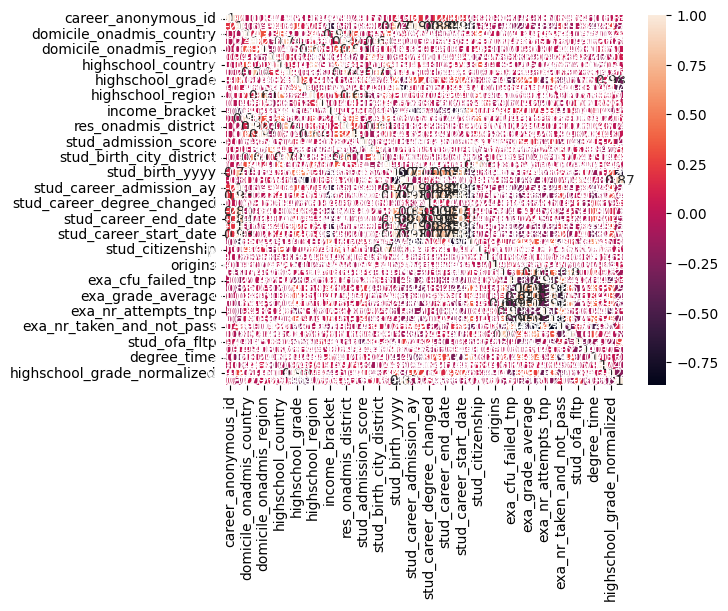

In [77]:
import seaborn as sns

df_features = df_originale_cleaned_encoded.drop("dropout", axis=1)

correlation_matrix = df_features.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

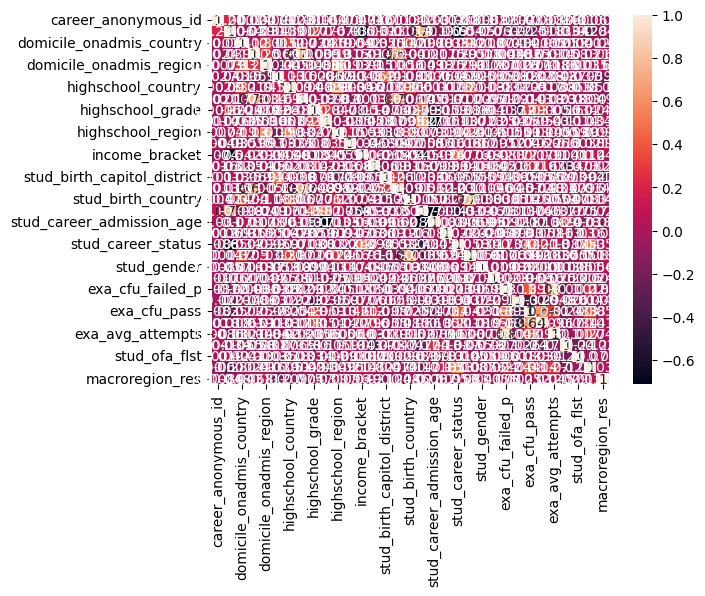

In [78]:
# Trova le coppie di features con correlazione superiore a una certa soglia
high_corr_features = set()  # Inizializza un insieme vuoto per memorizzare le features con alta correlazione
threshold = 0.8  # Soglia di correlazione

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

# Rimuovi le features altamente correlate
df_features_filtered = df_features.drop(columns=high_corr_features)

# Visualizza la nuova matrice di correlazione
correlation_matrix_filtered = df_features_filtered.corr()
sns.heatmap(correlation_matrix_filtered, annot=True)
plt.show()

In [79]:
# Trova le coppie di features con correlazione superiore a una certa soglia
high_corr_pairs = []  # Inizializza una lista vuota per memorizzare le coppie di features con alta correlazione
threshold = 0.8  # Soglia di correlazione

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))

# Stampare le coppie di features altamente correlate
for pair in high_corr_pairs:
    print(f"Features correlate: {pair[0]} - {pair[1]}, Correlazione: {pair[2]}")


Features correlate: res_onadmis_country - domicile_onadmis_country, Correlazione: 0.9215048928907112
Features correlate: res_onadmis_district - domicile_onadmis_district, Correlazione: 0.9800825552471476
Features correlate: res_onadmis_region - domicile_onadmis_region, Correlazione: 0.9459267414234384
Features correlate: stud_career_admission_ay - career_start_ay, Correlazione: 1.0
Features correlate: stud_career_admission_date - career_start_ay, Correlazione: 0.9805189108393106
Features correlate: stud_career_admission_date - stud_career_admission_ay, Correlazione: 0.9805189108393106
Features correlate: stud_career_end_ay - career_start_ay, Correlazione: 0.8327224315001192
Features correlate: stud_career_end_ay - stud_career_admission_ay, Correlazione: 0.8327224315001192
Features correlate: stud_career_end_date - career_start_ay, Correlazione: 0.8379358103103912
Features correlate: stud_career_end_date - stud_career_admission_ay, Correlazione: 0.8379358103103912
Features correlate: st

In [80]:
colonnes_da_eliminare = ["career_start_ay", "stud_career_start_ay", "highschool_grade", "highschool_grade_max"]

df_originale_cleaned_encoded = df_originale_cleaned_encoded.drop(colonnes_da_eliminare, axis=1)


In [10]:
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = df_originale_cleaned_encoded.drop("dropout", axis=1)
y = df_originale_cleaned_encoded["dropout"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=13
)

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values